#  Medical Cost Personal Datasets

https://www.kaggle.com/datasets/mirichoi0218/insurance/data

In [287]:
!pip install kagglehub
!pip install --upgrade seaborn

import pandas as pd
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import kagglehub

# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/mirichoi0218/insurance/versions/1


In [288]:
df = pd.read_csv(path + "/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [289]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


**age**: age of primary beneficiary (numerical)

**sex**: insurance contractor gender, female, male (categorical)

**bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9 (numerical)

**children**: Number of children covered by health insurance / Number of dependents (categorical)

**smoker**: Smoking (categorical)

**region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest. (categorical)

**charges**: Individual medical costs billed by health insurance (numerical)

In [290]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Cleaning data

Before we start analyzing the data, we need to make sure that there are no missing values, NA values, or duplicates in the dataset.

In [291]:
if df.isnull().values.any():
  print("Dataset has null values")
else:
  print("Dataset has no null values")

Dataset has no null values


In [292]:
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [293]:
if df.duplicated().values.any():
  print("Dataset has duplicates")
  print(df[df.duplicated()])
  df.drop_duplicates(inplace=True)
else:
  print("Dataset has no duplicates")

Dataset has duplicates
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


Data had one duplicate but we deleted it using df.drop_duplicates

# Data exploration

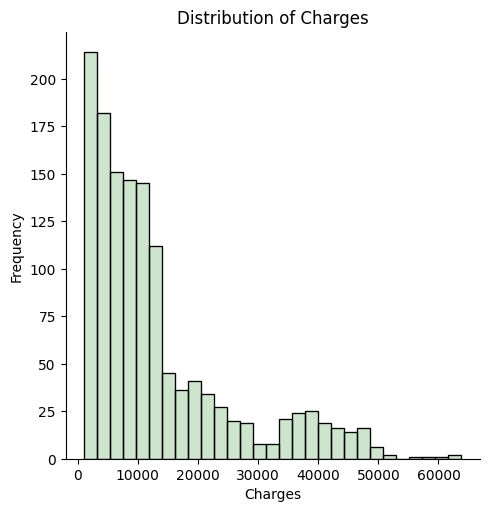

In [294]:
sns.displot(df['charges'], kind='hist', color='g', alpha=0.2)
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

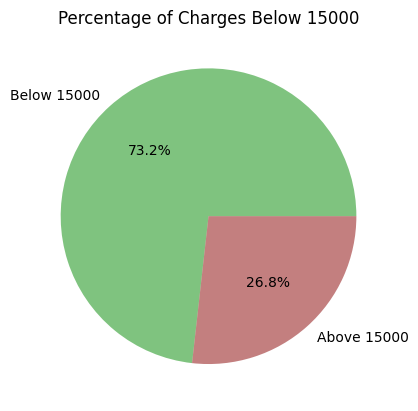

In [295]:
below_15000 = (df['charges'] < 15000).sum() / len(df) * 100
plt.pie([below_15000, 100 - below_15000], labels=['Below 15000', 'Above 15000'], autopct='%1.1f%%', colors=['#00880080', '#88000080'])
plt.title('Percentage of Charges Below 15000')
plt.show()

The distribution plot of charges shows that most people in the dataset have charges below 10000. Illustrating this with a pie chart, we get information that 73.2% of people have charges below 15000, which is consistent with the average obtained in df.describe, amounting to 13270.

Text(0, 0.5, 'Charges')

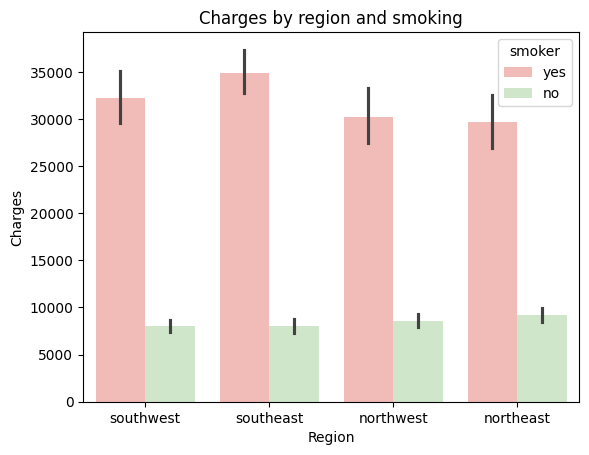

In [296]:
colors = sns.color_palette("Pastel1")
sns.barplot(x='region', y='charges', data=df, hue='smoker', palette=[colors[0], colors[2]])
plt.title('Charges by region and smoking')
plt.xlabel('Region')
plt.ylabel('Charges')

The 'Charges by region and smoking' chart clearly illustrates that charges are significantly higher for smokers, with the most pronounced difference observed in the southeast region.

<ipython-input-297-be19dc5be40e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_charges_by_sex.index, y=avg_charges_by_sex.values, palette=[colors[7], colors[4]])


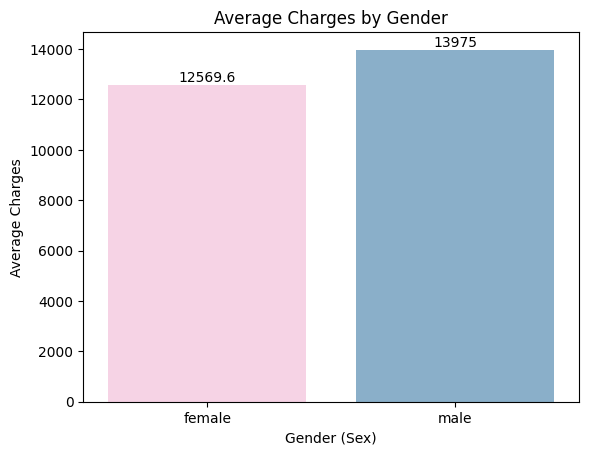

In [297]:
colors = sns.color_palette("Set3")
avg_charges_by_sex = df.groupby('sex')['charges'].mean()
ax = sns.barplot(x=avg_charges_by_sex.index, y=avg_charges_by_sex.values, palette=[colors[7], colors[4]])
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Average Charges by Gender')
plt.xlabel('Gender (Sex)')
plt.ylabel('Average Charges')
plt.show()

The chart provides information on the average charges based on gender. It is evident that males have higher charges.

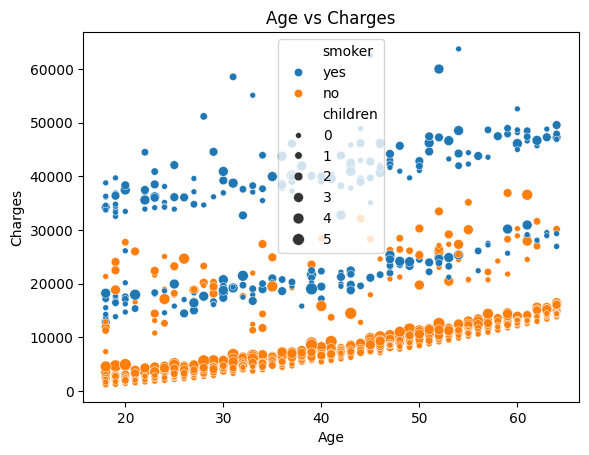

In [298]:
sns.scatterplot(x='age', y='charges', data=df, hue='smoker', size='children')
plt.title('Age vs Charges')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

This chart once again illustrates the significant impact of smoking status on charges

# Data encoding

Before we examine the exact correlation between factors, we need to get rid of object-type variables

In [299]:
df[['sex', 'smoker', 'region']] = df[['sex', 'smoker', 'region']].astype('category')
df.dtypes

,0
age,int64
sex,category
bmi,float64
children,int64
smoker,category
region,category
charges,float64


In [300]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex = label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker = label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region = label.transform(df.region)
df.dtypes

,0
age,int64
sex,int64
bmi,float64
children,int64
smoker,int64
region,int64
charges,float64


As you can see, the Dtype 'category' has been replaced by 'int64' by using LabelEncoder.

In [301]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   int64  
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   int64  
 5   region    1337 non-null   int64  
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 83.6 KB
None


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Our dataframe looks as follows. We still have 1337 entries, so we haven't lost anything during encoding. The 'sex' variable now takes values of {0 where it was 'female' and 1 where it was 'male'}, 'smoker' takes 1 if the person smokes and 0 if not. 'Region' takes 3 for 'southwest', 2 for 'southeast', 1 for 'northwest', and 0 for 'northeast

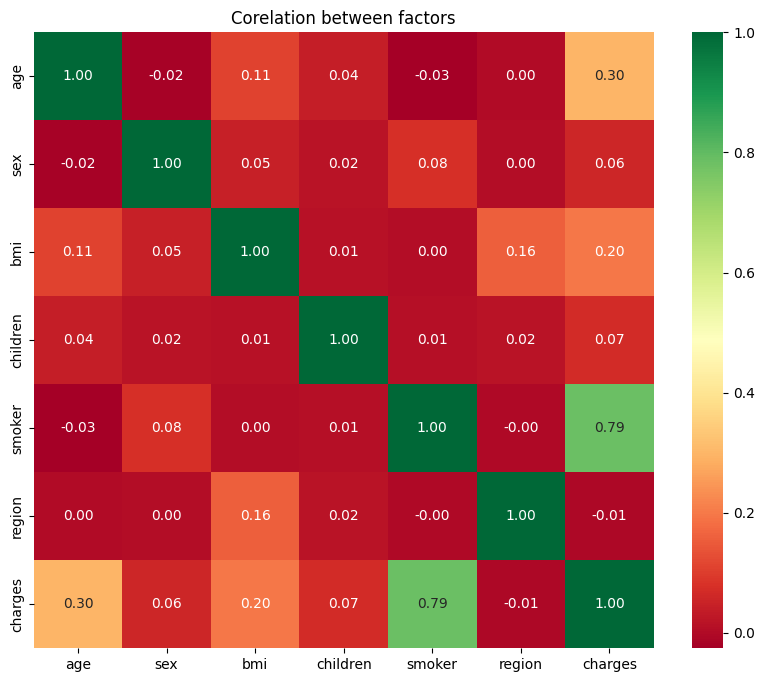

In [302]:

cols = ['charge', 'bmi', 'children', 'smoker',
        'region', 'age']

corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Corelation between factors')
plt.show()

The correlation matrix clearly shows that the main factors influencing 'charges' are whether a person is a smoker, their age, and their BMI

# Linear Regression

Mse: 143870088.7826585
Intercept: [2372.21229158]
Coefficients: [277.75910138]
Score: 0.053119928854146514


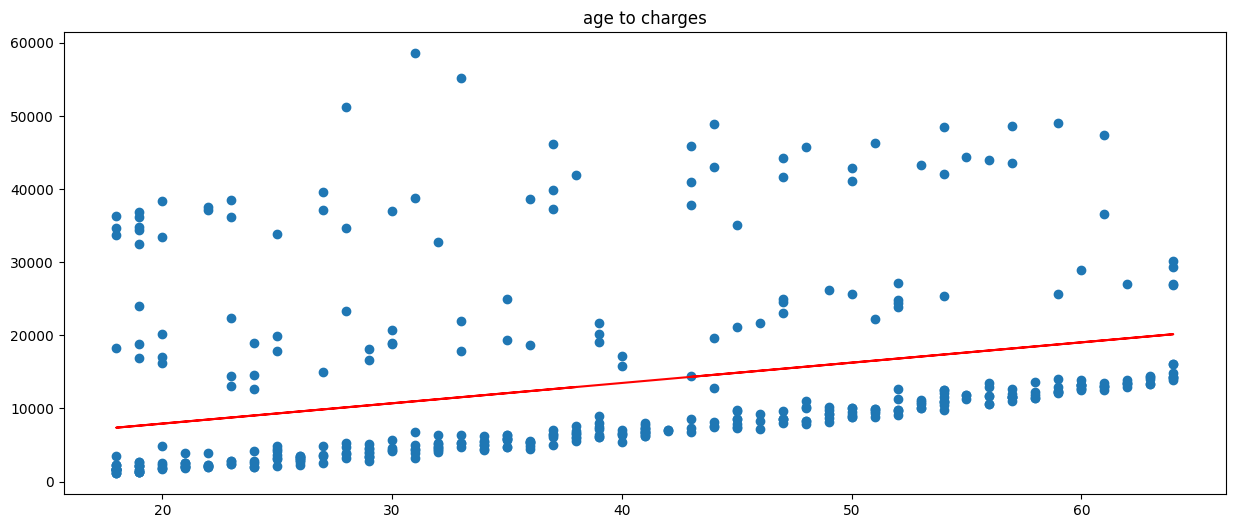

In [303]:
X = df[['age']]
y = df[['charges']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Mse: {mean_squared_error(y_pred, y_test)}")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_[0]}")
print(f"Score: {model.score(X_test, y_test)}")

plt.figure(figsize=(15,6))
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red')
plt.ticklabel_format(style='plain')
plt.title('age to charges')
plt.show()

By creating a simple linear regression of age to charges, we can observe that our model does not achieve a very accurate fit.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid

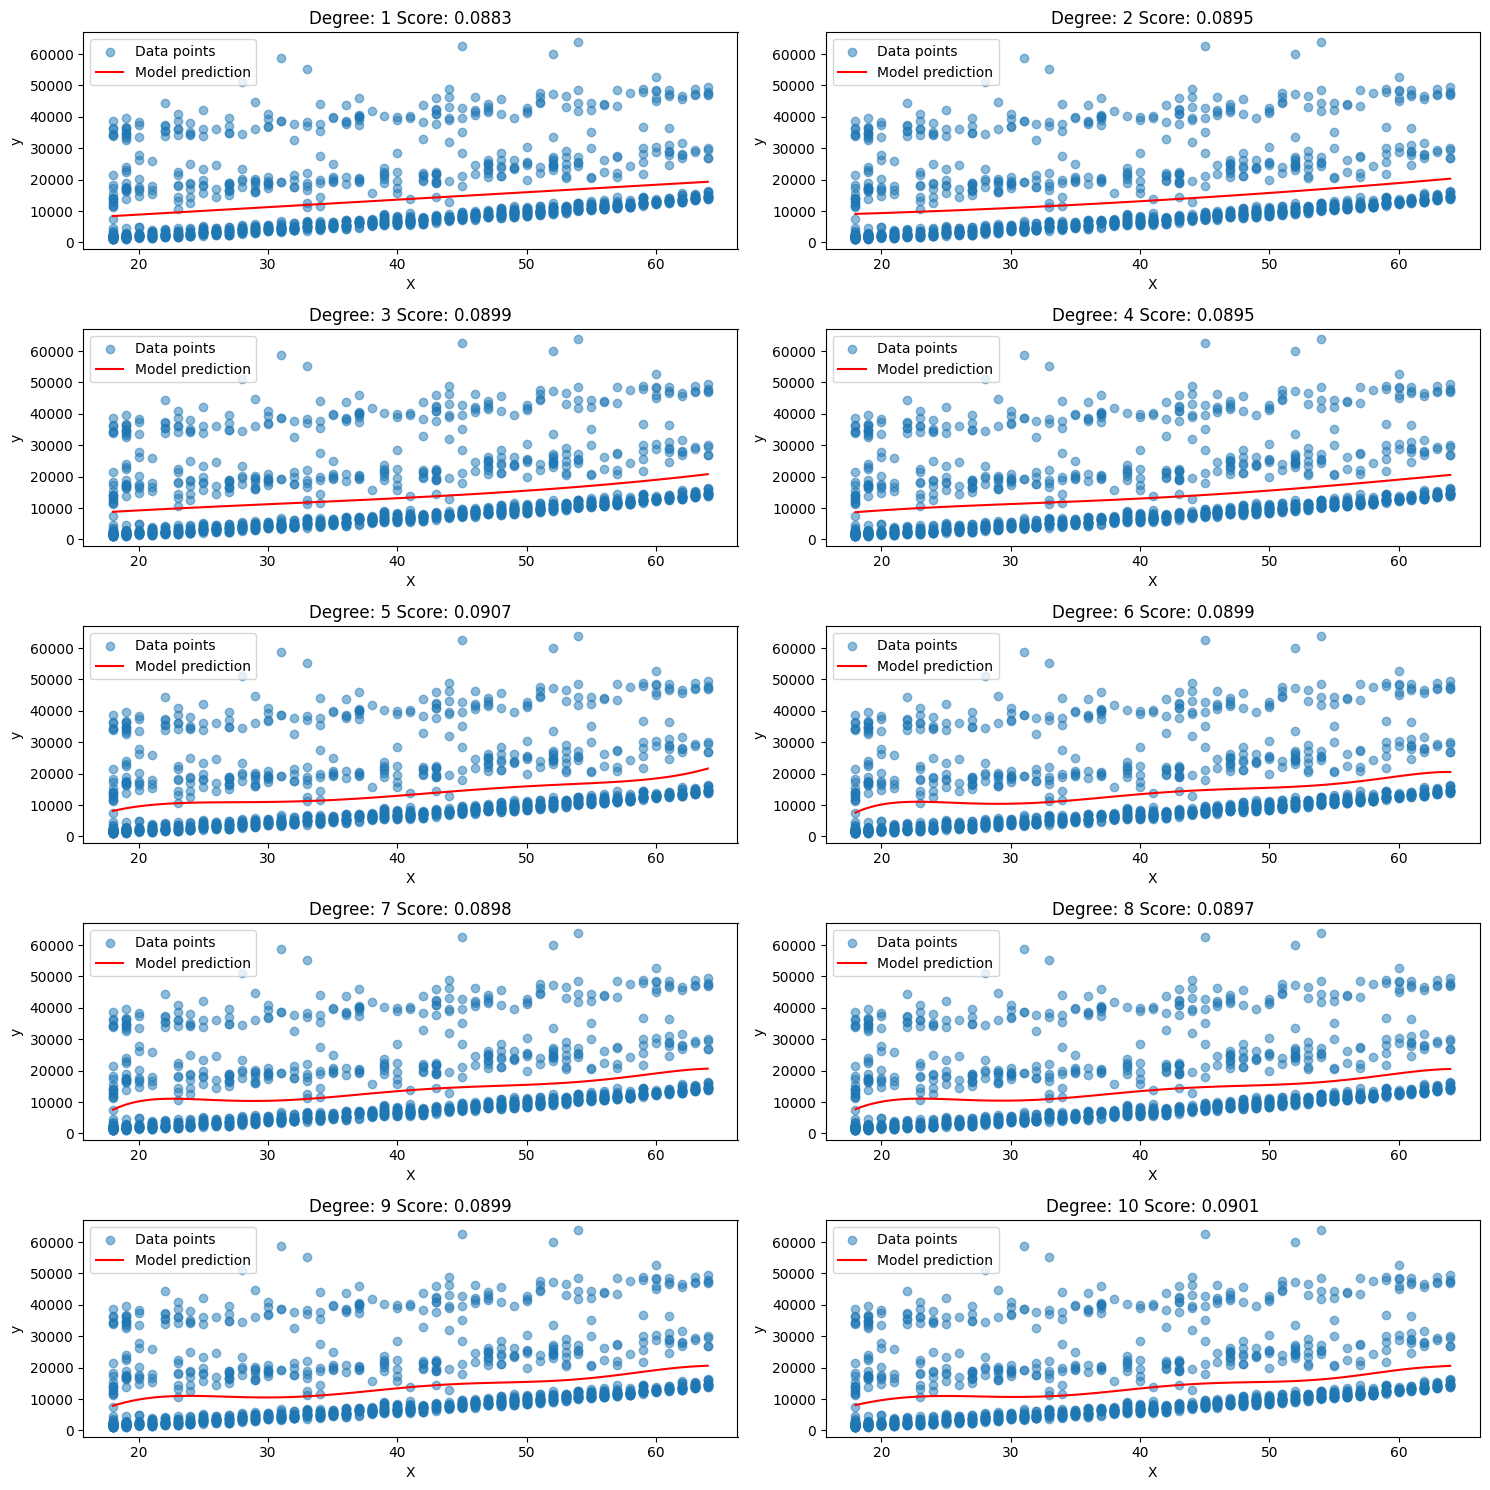

In [304]:
fig, axis = plt.subplots(5, 2, figsize=(15, 15))
train_errors = []
test_errors = []
errors = []

X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

for order in range(1, 11):
    poly = PolynomialFeatures(order, include_bias=False)
    X_order = poly.fit_transform(X)
    X_range_order = poly.transform(X_range)

    X_train, X_test, y_train, y_test = train_test_split(X_order, y, test_size=0.3, random_state=44)

    model_order = LinearRegression()
    model_order.fit(X_train, y_train)

    y_train_pred = model_order.predict(X_train)
    y_test_pred = model_order.predict(X_test)
    y_range_pred = model_order.predict(X_range_order)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    mse = mean_squared_error(y, model_order.predict(X_order))

    train_errors.append(train_mse)
    test_errors.append(test_mse)
    errors.append(mse)

    row = (order - 1) // 2
    col = (order - 1) % 2

    axis[row, col].scatter(X, y, alpha=0.5, label="Data points")
    axis[row, col].plot(X_range, y_range_pred, color='red', label="Model prediction")
    axis[row, col].set_title(f"Degree: {order} Score: {model_order.score(X_order, y):.4f}")
    axis[row, col].set_xlabel("X")
    axis[row, col].set_ylabel("y")
    axis[row, col].legend()

plt.tight_layout()
plt.show()


We observe that as the degree increases, our score coefficient also increases, reaching a value of 0.0915.

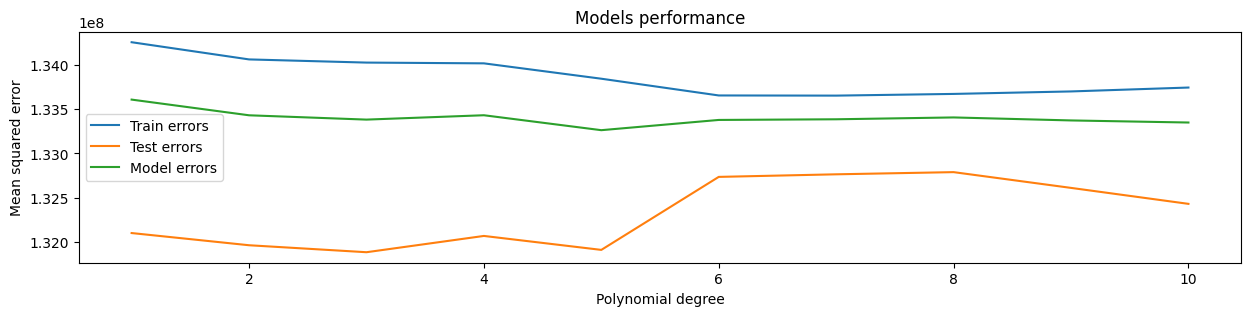

In [305]:
plt.figure(figsize=(15, 3))
plt.plot(range(1, 11), train_errors, label="Train errors")
plt.plot(range(1, 11), test_errors, label="Test errors")
plt.plot(range(1, 11), errors, label="Model errors")
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.title("Models performance")

plt.legend()
plt.show()


We can observe an increase in test errors at 4 degrees and a very significant increase at 6 degrees, which indicates that our model is overfitting.

Mean squared error equals: 38782889.81423138
Intercept: -10260.44593039717
Coefficients: 242.976733218313
Score: 0.7631717420685994


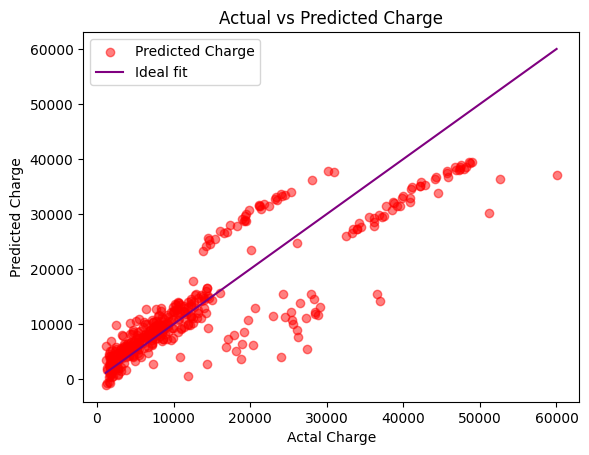

In [306]:
X = df.drop(['charges'], axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LinearRegression()
_= model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Mean squared error equals: {0}".format(mean_squared_error(y_pred, y_test)))
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_[0]}")
print(f"Score: {model.score(X_test, y_test)}")


plt.scatter(y_test, y_pred, color='red', label='Predicted Charge', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], label='Ideal fit', color='purple')
plt.xlabel("Actal Charge")
plt.ylabel("Predicted Charge")
plt.title("Actual vs Predicted Charge")
plt.legend()
plt.show()

The purple line on the chart represents the ideal fit. We can see that some predicted values deviate significantly from the ideal fit."

# Enchancing the model

Mean Squared Error: 156420785.39358026
R-squared Score: 0.2472170235508001


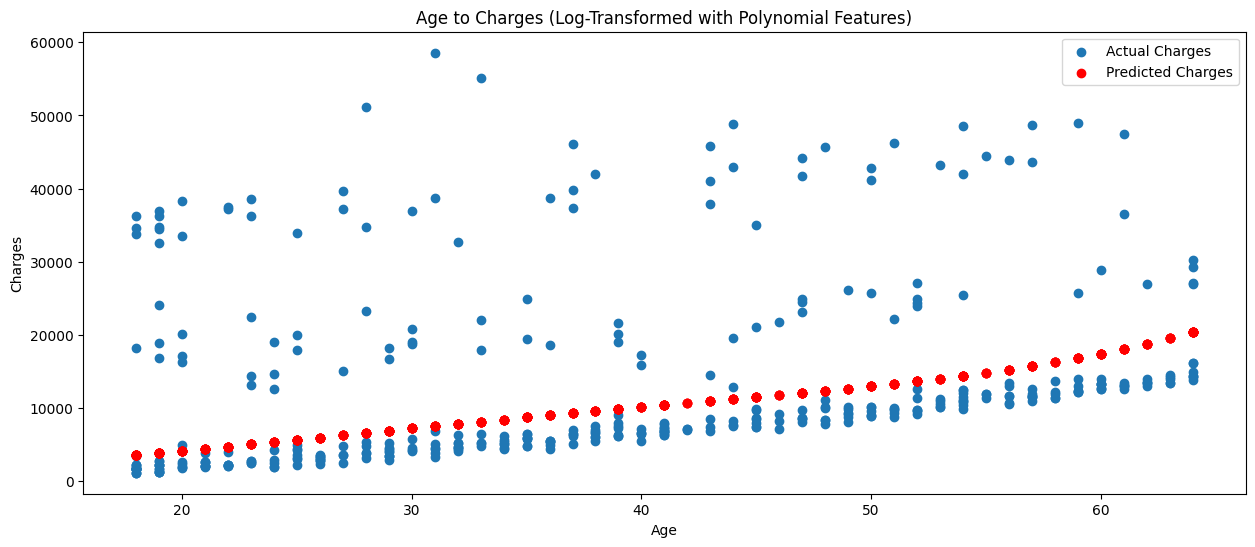

In [307]:

X = df[['age']]
y = df[['charges']]

y_log = np.log(y + 1)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train_log, y_test_log = train_test_split(X_poly, y_log, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train_log)

y_pred_log = model.predict(X_test)

y_pred = np.exp(y_pred_log) -1

mse = mean_squared_error(y_pred, np.exp(y_test_log) -1 )
score = model.score(X_test, y_test_log)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {score}")

plt.figure(figsize=(15, 6))
plt.scatter(X_test[:, 0], np.exp(y_test_log) - 1, label='Actual Charges')
plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted Charges')
plt.ticklabel_format(style='plain')
plt.title('Age to Charges (Log-Transformed with Polynomial Features)')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend()
plt.show()

In the initial 'age to charges' plot, we had an MSE of 130,374,413.23 and a score of 0.06. After applying a logarithmic transformation and using a 3rd-degree polynomial, we significantly improved the score and reduced the Mean Squared Error.

Let's consider how we can further improve the model's accuracy. We can remove outliers that fall outside 1.5 times the IQR below the first quartile (Q1) or above the third quartile (Q3).

In [308]:
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    filtered_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

filtered_df = df[(df['age'] >= lower_bound_age) & (df['age'] <= upper_bound_age) &
                 (df['charges'] >= lower_bound_charges) & (df['charges'] <= upper_bound_charges)]

 Since the correlation matrix indicated a relationship between 'age', 'bmi', and 'smoker', lets try creating an interaction term by multiplying these features together (e.g., df['age_bmi_smoker'] = df['age'] * df['bmi'] * df['smoker']).

<ipython-input-309-358f15f86300>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['age_bmi_smoker'] = filtered_df['age'] * filtered_df['bmi'] * filtered_df['smoker']


Mean Squared Error: 19954964.984012242
R-squared Score: 0.6896296207153089


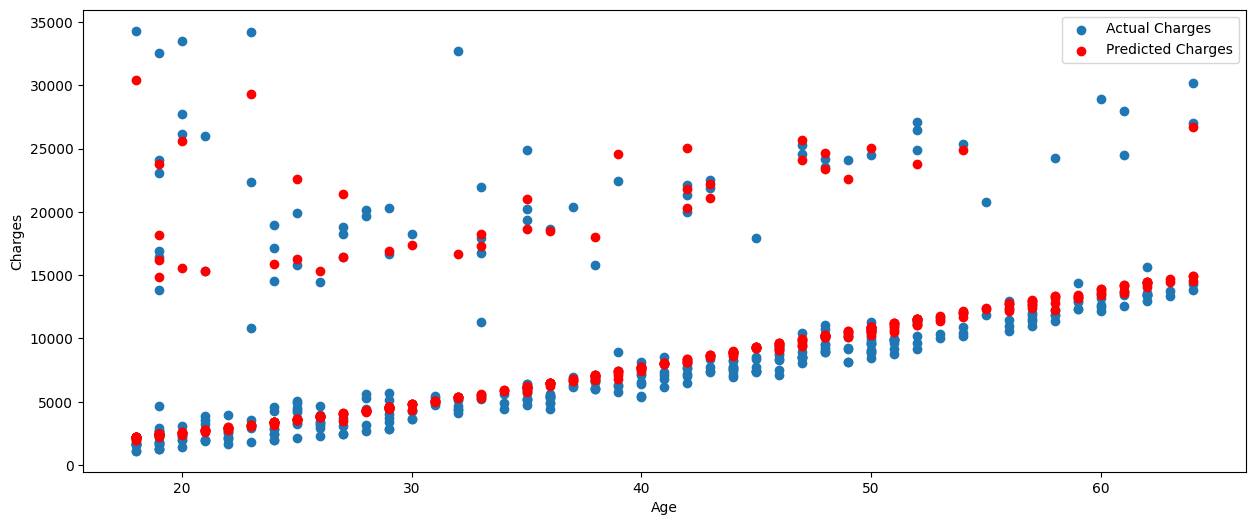

In [309]:
filtered_df['age_bmi_smoker'] = filtered_df['age'] * filtered_df['bmi'] * filtered_df['smoker']
X = filtered_df[['age', 'bmi', 'smoker', 'age_bmi_smoker']]
y = filtered_df[['charges']]

y_log = np.log(y + 1)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train_log, y_test_log = train_test_split(X_poly, y_log, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train_log)

y_pred_log = model.predict(X_test)

y_pred = np.exp(y_pred_log) -1

mse = mean_squared_error(y_pred, np.exp(y_test_log) -1 )
score = model.score(X_test, y_test_log)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {score}")

plt.figure(figsize=(15, 6))
plt.scatter(X_test[:, 0], np.exp(y_test_log) - 1, label='Actual Charges')
plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted Charges')
plt.ticklabel_format(style='plain')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend()
plt.show()

As a result we get a higher score and lower mse